In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# технический блок для импортов
import pandas as pd
import dtale
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce 
from scipy.stats import kruskal
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency



ИССЛЕДОВАНИЕ ДАННЫХ HR-АГЕНТСТВА

ЗАДАЧА:

В процессе своего анализа вы должны:

1) Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.

А также ответить на ключевые вопросы HR-агентства:

2) Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

3) Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

4) Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

5) Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

 Если вы найдёте в данных интересные закономерности, также отметьте их в своём анализе.


Продемонстрируйте использование разных тестов для проверки статистической значимости сделанных выводов:

тесты для количественного признака:
для одной выборки;
для двух выборок;
для нескольких выборок;
тест для категориальных признаков.

ДОПОЛНИТЕЛЬНЫЕ ЗАДАЧИ:
6) Провести дополнительное исследование:
Студент самостоятельно корректно сформулировал минимум две дополнительных бизнес-гипотезы о влиянии факторов на заработную плату специалистов и для каждой гипотезы:
представил визуальный анализ данных;
произвёл статистическое тестирование;
сделал верные, соответствующие бизнес-вопросам выводы по полученным результатам.

## Шаг 1: Загрузка данных



In [2]:
data = pd.read_csv('./data/ds_salaries.csv')
# Удаление колонки 'Unnamed: 0', если она существует ессли эту колонку не удалить ты дубликаты найдены не будут. Не очень понимаю правильно ли ее удалять
if 'Unnamed: 0' in data.columns:
    data_cleaned = data.drop(columns=['Unnamed: 0'])
else:
    data_cleaned = data.copy()
data_cleaned



,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L
...,...,...,...,...,...,...,...,...,...,...,...
602,2022,SE,FT,Data Engineer,154000,USD,154000,US,100,US,M
603,2022,SE,FT,Data Engineer,126000,USD,126000,US,100,US,M
604,2022,SE,FT,Data Analyst,129000,USD,129000,US,0,US,M
605,2022,SE,FT,Data Analyst,150000,USD,150000,US,100,US,M


## Шаг 2: Обработка и очистка данных

На этом этапе мы провели предварительную обработку данных. Было проверено наличие дубликатов, пропусков, а также приведены в порядок типы данных в каждой колонке. 

In [3]:
missing_count = data_cleaned.isna().sum()
print('Пропуски в данных')
print(missing_count)
# видим что видимых пропусков нет

# Получаем таблицу с дубликатами до их удаления
duplicates_only = data_cleaned[data_cleaned.duplicated(keep=False)]
duplicates_only
# тут мы видим что дубликаты в данных имеются но честно говоря не  понятно это просто 2 разных человека с одинаковыми параметрами или дубликаты?
#  далее будем рассматривать их как дубликаты но в целом я считаю можно этого и не делать.

# Удаление только полных дубликатов
data_cleaned_no_full_duplicates = data_cleaned.drop_duplicates()
# Количество удалённых дубликатов
duplicates_removed = len(data_cleaned) - len(data_cleaned_no_full_duplicates)
print(f"Всего удалено {duplicates_removed} полных дубликатов.")

# Вывод дубликатов
print("Дубликаты до удаления:")
print(duplicates_only)
# присваиваем в переменную df data_cleaned_no_full_duplicates для краткости
df = data_cleaned_no_full_duplicates





Пропуски в данных
work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64
Всего удалено 42 полных дубликатов.
Дубликаты до удаления:
     work_year experience_level employment_type       job_title  salary  \
119       2021               MI              FT   Data Engineer  200000   
181       2021               MI              FT  Data Scientist   76760   
217       2021               MI              FT  Data Scientist   76760   
256       2021               MI              FT   Data Engineer  200000   
303       2022               SE              FT  Data Scientist  123000   
..         ...              ...             ...             ...     ...   
587       2022               SE              FT  Data Scientist  140000   
588       2022               SE              F

In [4]:
# Проверка типов данных столбцов
print(df.dtypes)
df.head(3)
# похоже все столбцы имеют правильный формат. все что цифра - int все что строки object, 
# возможно work_year имеет смысл приравнять к категориальным значениям так ка у нас всего 3 типа года или
# можно было бы пордумать о приведении года к дате но пока мне кажется в этом нет смысла

work_year              int64
experience_level      object
employment_type       object
job_title             object
salary                 int64
salary_currency       object
salary_in_usd          int64
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
dtype: object


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M


Студент определил в данных неинформативные признаки, которые не будут участвовать в исследовании.

## Шаг 3: Удаление не имеющих смысла для исследования столбцов



Я считаю что столбец salary и salary_currency нам в дальнейшем уже не нужны так как у нас имеются универсальный столбец salary_in_usd. удаляем их


In [5]:
df = df.drop(columns=['salary','salary_currency'])

## Шаг 4: Классификация данных



work_year             - категориальный - так как у него 3 уникальных значения обозначающих года
experience_level      - категориальный
employment_type       - категориальный
job_title             - категориальный
salary_in_usd         - цифровой
employee_residence    - категориальный
remote_ratio          - категориальный так как есть всего 3 значения 0 , 50 и 100
company_location      - категориальный
company_size          - категориальный


## Шаг 5: Поиск основных статистических величин



In [6]:

# быстрый анализ показывает следующие значения
# work_year - max  2022 min 2020 median 2021 mode 2022
# experience_level Frequent:SE (43.01%) Frequency:243  || SE (243), MI (208), EN (88), EX (26)
# employment_type FT (96.64%) Frequency:546 || FT (546), PT (10), CT (5), FL (4)
# job_title Most Frequent:Data Scientist (23.01%) Frequency:130 || 
# salary_in_usd max 600 000 min 2 859, mean: 110 610, mode: 100 000
# employee_residence Most Frequent:US (52.21%) Frequency:295 US (295), GB (43), IN (30), CA (27), DE (24), FR (18), ES (15), GR (12), JP (7), BR (6), PK (6), PT (6), NL (5), IT (4), PL (4), RU (4) ....other
# remote_ratio Most Frequent:100 (61.24%) || median:100 , 100 (346), 0 (121), 50 (98)
# company_location  Most Frequent:US (56.28%) Frequency:318 || US (318), GB (46), CA (28), DE (27), IN (24), FR (15), ES (14), GR (10), JP (6), AT (4), NL (4), PL (4), PT (4), AE (3), AU (3), other...\
# company_size Most Frequent:M (51.33%) Frequency:290 Unique Row Values (top 100 most common):M (290), L (193), S (82)

## ЭТАП РАЗВЕДЫВАТЕЛЬНОГО АНАЛИЗА



Разведывательный анализ данных (4 балла)

2.1. Визуальный анализ данных (2 балла)



Студент выполнил визуальный анализ данных.

Сделан базовый анализ для каждого признака, участвующего в исследовании:
для числовых признаков построены гистограммы, иллюстрирующие распределения;
для категориальных признаков определено количество записей для каждой категории и построены соответствующие визуализации.

Студент создал корректные визуализации, которые демонстрируют влияние каждого из признаков, участвующих в исследовании, на зарплату по всем наименованиям Data Scientist или на зарплату по всем должностям.

Студент на основе визуального анализа дал первичные ответы на поставленный в задании вопрос: «Какие факторы влияют на заработную плату?».


в целом необходимы гистограммы можно посмотреть в  d = dtale.show(df) но в целях тренировки давайте выполним это так как учились желать это вручную

## Визуализация

2024-09-26 16:01:34,939 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-26 16:01:34,950 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


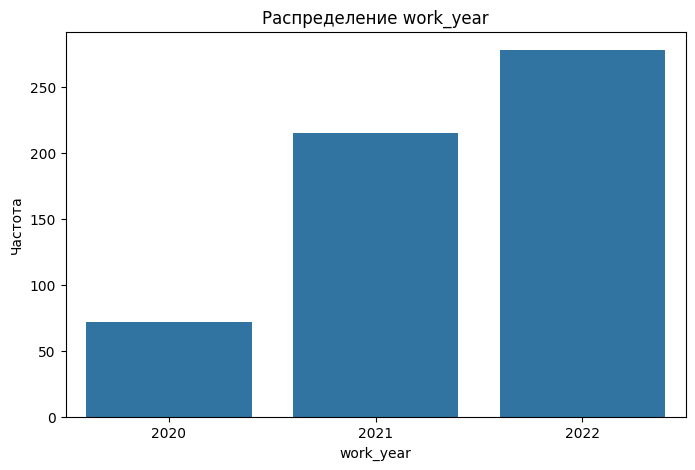

In [7]:
# work_year
col = 'work_year'
plt.figure(figsize=(8, 5))
sns.countplot(x=df[col].astype(str))  # Используем countplot для категориального признака
plt.title(f'Распределение {col}')
plt.xlabel(col)
plt.ylabel('Частота')
plt.show()
# ниже на графике мы видим распределение по годам. 

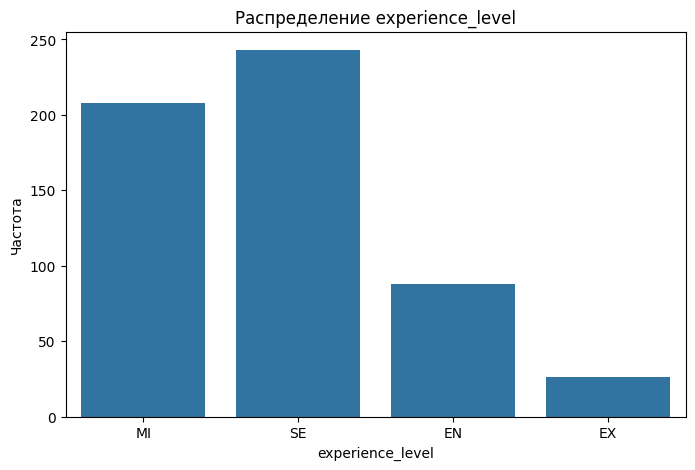

In [8]:
# experience_level
col = 'experience_level'
plt.figure(figsize=(8, 5))
sns.countplot(x=df[col].astype(str))  # Используем countplot для категориального признака
plt.title(f'Распределение {col}')
plt.xlabel(col)
plt.ylabel('Частота')
plt.show()
# ниже на графике мы видим распределение по уровню должностей.

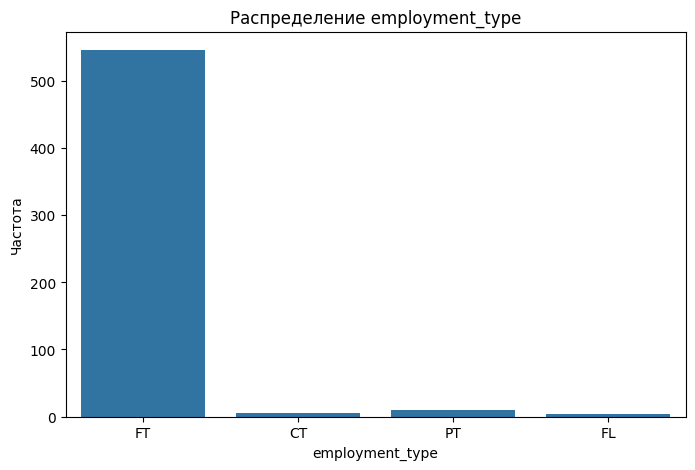

In [9]:
col = 'employment_type'
plt.figure(figsize=(8, 5))
sns.countplot(x=df[col].astype(str))  # Используем countplot для категориального признака
plt.title(f'Распределение {col}')
plt.xlabel(col)
plt.ylabel('Частота')
plt.show()
# видим что преобладает фулл тайм занятость 

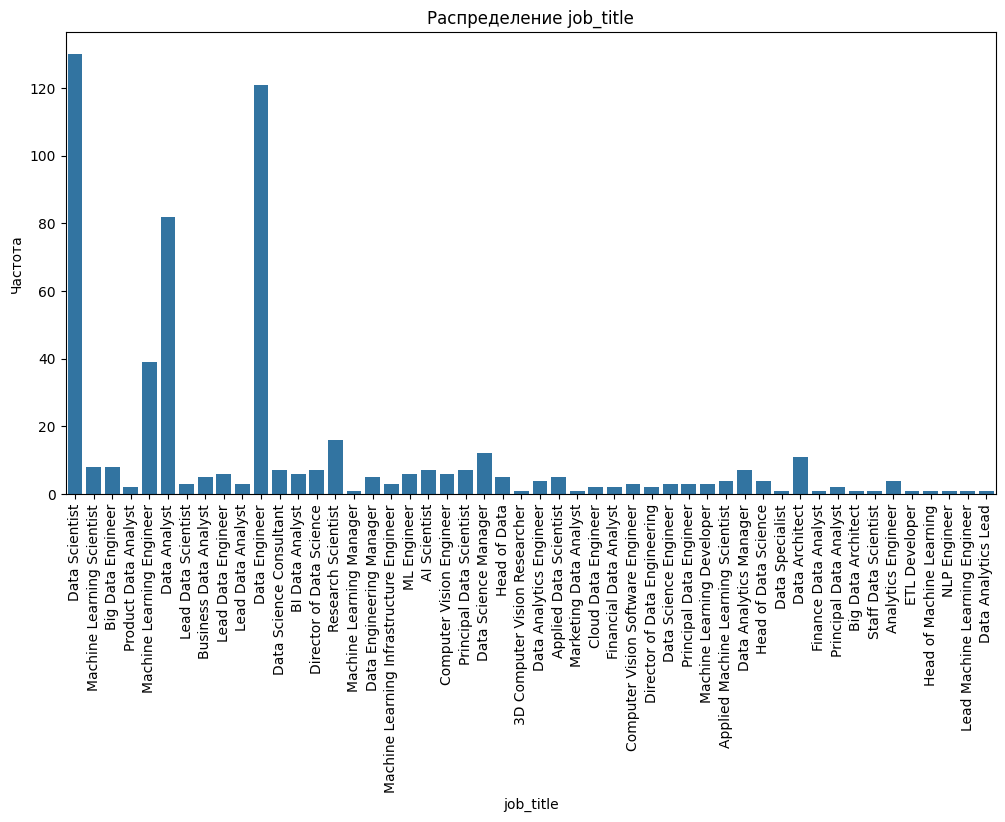

In [10]:
col = 'job_title'
plt.figure(figsize=(12, 6))
sns.countplot(x=df[col].astype(str))  # Используем countplot для категориального признака
plt.title(f'Распределение {col}')
plt.xlabel(col)
plt.ylabel('Частота')
plt.xticks(rotation=90)  # Поворот на 90 градусов
plt.show()


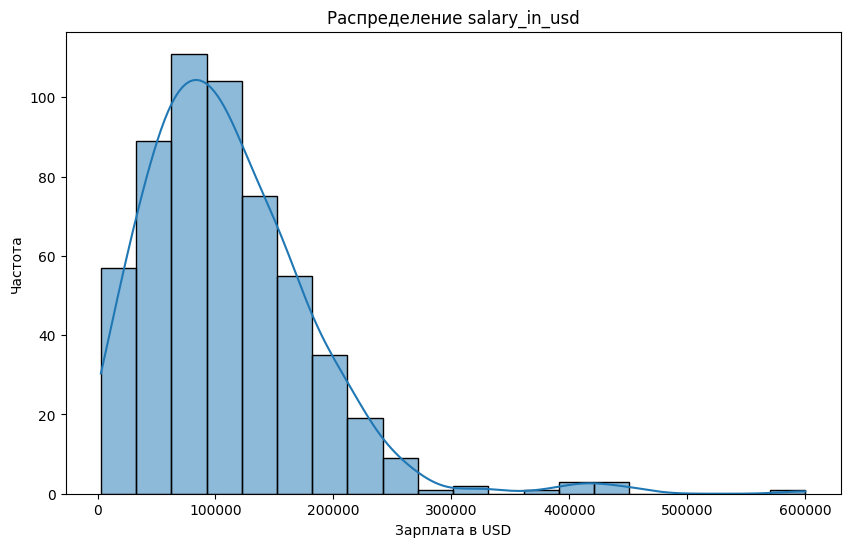

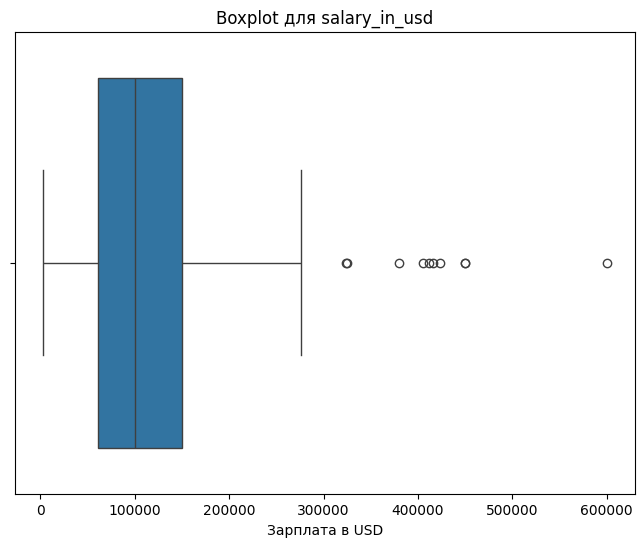

In [11]:
col = 'salary_in_usd'

# 1. Гистограмма для распределения зарплаты
plt.figure(figsize=(10, 6))
sns.histplot(df[col], bins=20, kde=True)  # kde=True добавит кривую плотности для визуализации распределения
plt.title(f'Распределение {col}')
plt.xlabel('Зарплата в USD')
plt.ylabel('Частота')
plt.show()

# 2. Boxplot для выявления выбросов и анализа медианы
plt.figure(figsize=(8, 6))
sns.boxplot(x=df[col])
plt.title(f'Boxplot для {col}')
plt.xlabel('Зарплата в USD')
plt.show()
# по графикам с зп видим возможные выбросы в сторону увеличения зп, но в любом случае распределение не будет являться нормальным

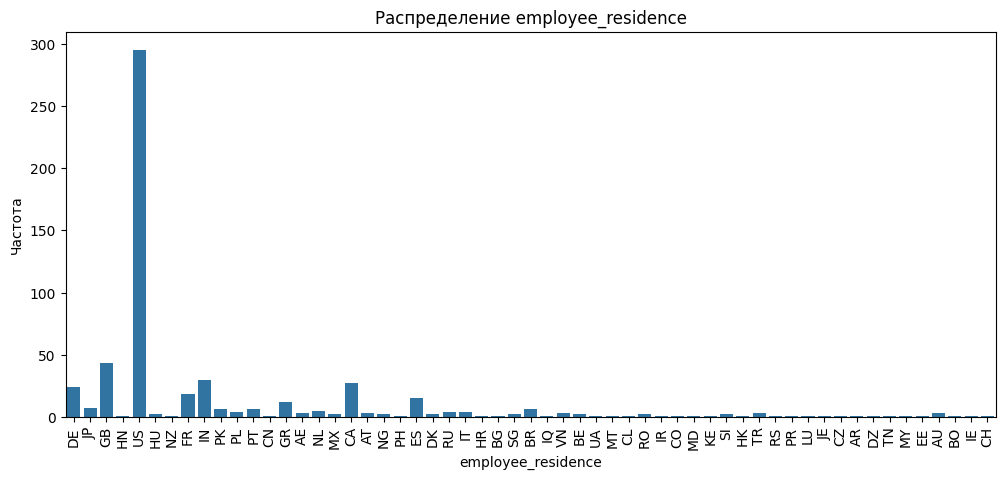

In [12]:
col = 'employee_residence'
plt.figure(figsize=(12, 5))
sns.countplot(x=df[col].astype(str))  # Используем countplot для категориального признака
plt.title(f'Распределение {col}')
plt.xlabel(col)
plt.ylabel('Частота')
plt.xticks(rotation=90)  # Поворот на 90 градусов

plt.show()
# видим что большая часть сосредоточена в штатах 

2024-09-26 16:01:36,428 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-26 16:01:36,434 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


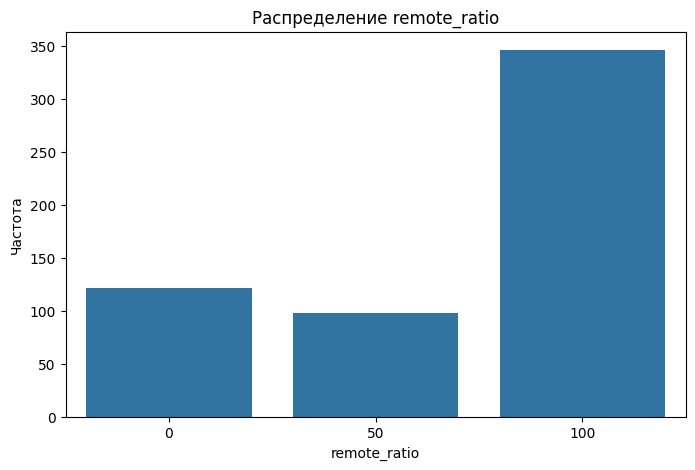

In [13]:
col = 'remote_ratio'
plt.figure(figsize=(8, 5))
sns.countplot(x=df[col].astype(str))  # Используем countplot для категориального признака
plt.title(f'Распределение {col}')
plt.xlabel(col)
plt.ylabel('Частота')
plt.show()
# преобладает удаленная работа - ранее мы договорились считать этот признак категориальным

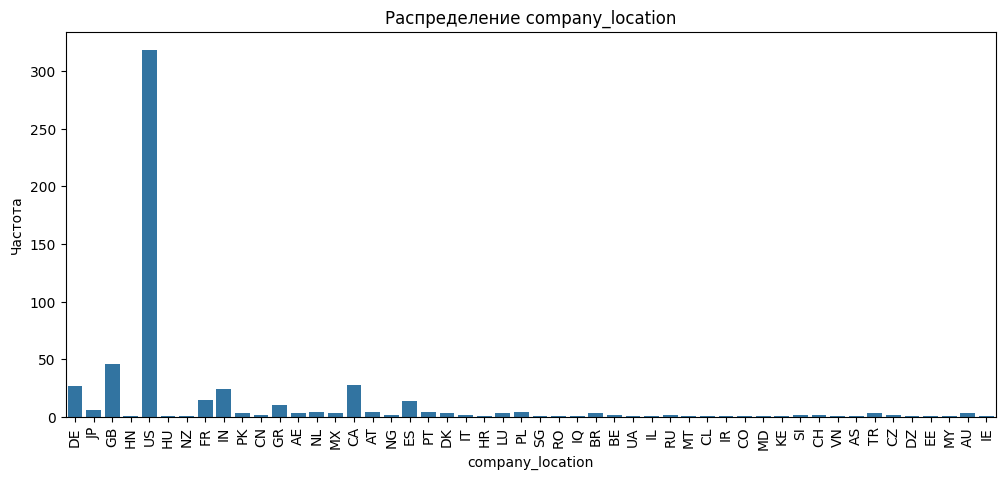

In [14]:
col = 'company_location'
plt.figure(figsize=(12, 5))
sns.countplot(x=df[col].astype(str))  # Используем countplot для категориального признака
plt.title(f'Распределение {col}')
plt.xlabel(col)
plt.ylabel('Частота')
plt.xticks(rotation=90)  # Поворот на 90 градусов
plt.show()
# похожая история с employee_residence доминируют штаты 


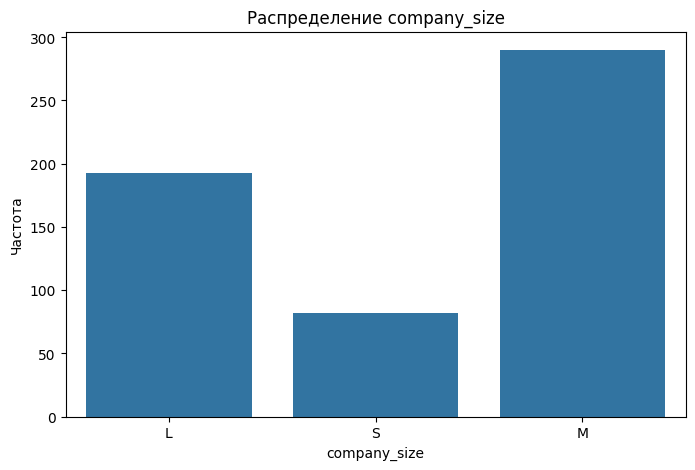

In [15]:
col = 'company_size'
plt.figure(figsize=(8, 5))
sns.countplot(x=df[col].astype(str))  # Используем countplot для категориального признака
plt.title(f'Распределение {col}')
plt.xlabel(col)
plt.ylabel('Частота')
plt.show()
# вто такое вот распределение по размеру компании

## ЭТАП АНАЛИЗА КОРРЕЛЯЦИЙ

сделаем тепловую матрицу корреляций что бы исследовать как каждый из признаков влияет на заработную плату

<Axes: >

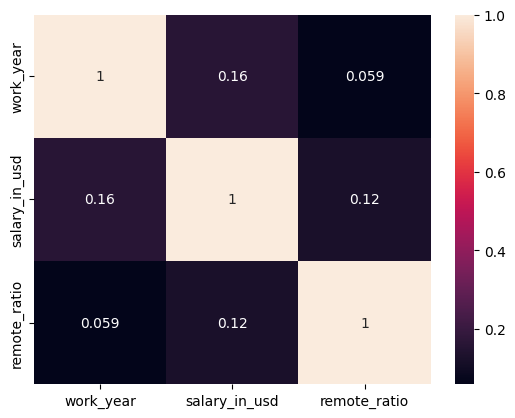

In [16]:
sns.heatmap(df.corr(numeric_only=True), annot=True)


In [17]:
df

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,US,50,US,L
...,...,...,...,...,...,...,...,...,...
602,2022,SE,FT,Data Engineer,154000,US,100,US,M
603,2022,SE,FT,Data Engineer,126000,US,100,US,M
604,2022,SE,FT,Data Analyst,129000,US,0,US,M
605,2022,SE,FT,Data Analyst,150000,US,100,US,M


мы видим что мы в данной матрице мы можем исследовать корреляцию только лишь 3 параметров так как все остальные не числовые. следовательно нам нужно закодировать нечисловые параметры

## ОТМЕНА ЭТАПА АНАЛИЗА КОРРЕЛЯЦИЙ 


## ПЕРЕХОД К ЭТАПУ КОДИРОВАНИЯ ДАННЫХ

начнем с experience_level - у нас в данной категории всего 4 уникальных значения
experience_level Frequent:SE (43.01%) Frequency:243  || SE (243), MI (208), EN (88), EX (26)
данный признак можнорассматривать как Порядковый где EN начальный уровень далее  MI далее SE далее EX 

In [18]:
# создаем объект OrdinalEncoder, col - имя столбца, mapping - словарь с описанием кодировки
ord_encoder = ce.OrdinalEncoder(mapping=[{
	'col': 'experience_level',
	'mapping': {'EN': 1, 'MI': 2, 'SE': 3, 
                'EX': 4}
}])
df
# # применяем трансформацию к столбцу
data_bin = ord_encoder.fit_transform(df[['experience_level']])
data_bin.columns = ['experience_level_encoded']
# добавляем результат к исходному DataFrame
df = pd.concat([df, data_bin], axis=1)
# удаляем старый столбец
df = df.drop(columns=['experience_level'])
# проверяем все ли в порядке
df
#  полный порядок столбец закодирован

,work_year,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,experience_level_encoded
0,2020,FT,Data Scientist,79833,DE,0,DE,L,2
1,2020,FT,Machine Learning Scientist,260000,JP,0,JP,S,3
2,2020,FT,Big Data Engineer,109024,GB,50,GB,M,3
3,2020,FT,Product Data Analyst,20000,HN,0,HN,S,2
4,2020,FT,Machine Learning Engineer,150000,US,50,US,L,3
...,...,...,...,...,...,...,...,...,...
602,2022,FT,Data Engineer,154000,US,100,US,M,3
603,2022,FT,Data Engineer,126000,US,100,US,M,3
604,2022,FT,Data Analyst,129000,US,0,US,M,3
605,2022,FT,Data Analyst,150000,US,100,US,M,3


## ВИЗУАЛИЗАЦИЯ КОРРЕЛЯЦИИ

посмотрим как коррелируют(во всех категориальных признаках будем использовать корреляцию Спирмена) новые закодированные столбцы с зарплатой:


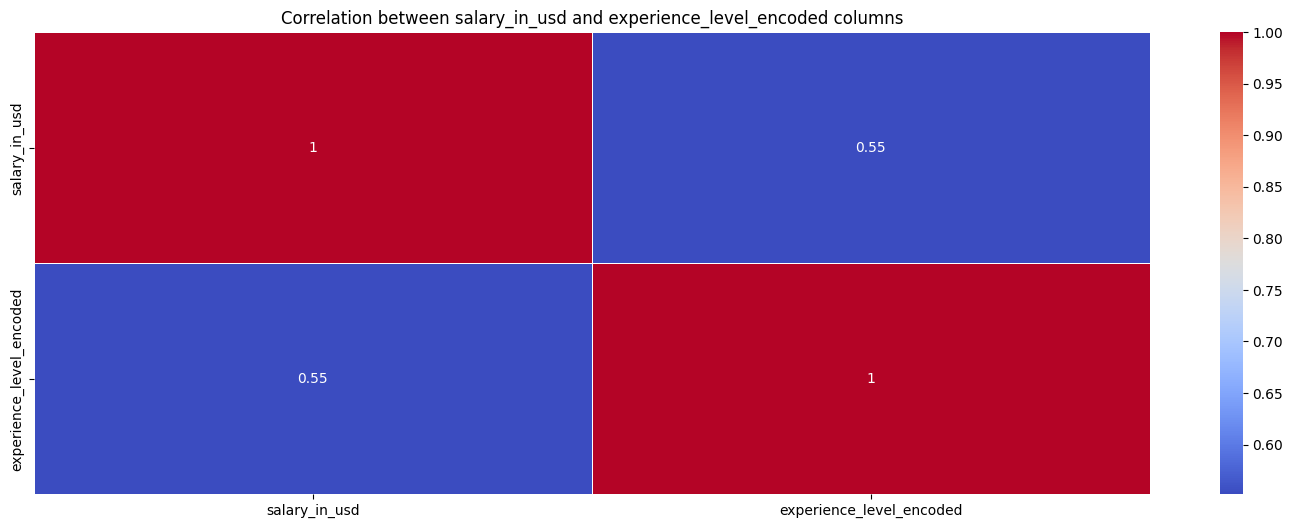

In [19]:
experience_level_encoded = [col for col in df.columns if col.startswith('experience_level_encoded')]
# 2. Добавляем 'salary_in_usd' к выбранным столбцам
columns_of_interest = ['salary_in_usd'] + experience_level_encoded
# 3. Строим тепловую карту корреляций только для этих столбцов
plt.figure(figsize=(18, 6))
sns.heatmap(df[columns_of_interest].corr(method = 'spearman'), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation between salary_in_usd and experience_level_encoded columns')
plt.show()

## Промежуточный вывод

Уровень экспертности имеет среднюю положительную корреляцию с зп.

## Кодирование

переходим ко второму столбцу employment_type 
его значениями могу быть  FT (546), PT (10), CT (5), FL (4)
в данном случае я могу отнести этот признак к Номинальным, так как нет определленного логического способо проранжировать эти значения.
Смотрим схему выбора кодировки и приходим к выовду что  будем использовать OneHot Encoding.
Поехали!

In [20]:
encoder = ce.OneHotEncoder(cols=['employment_type'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(df['employment_type'])
df = pd.concat([df, type_bin], axis=1)
# удаляем старый столбец
df = df.drop(columns=['employment_type'])
# проверяем все ли в порядке
df
#  полный порядок столбец закодирован

,work_year,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,experience_level_encoded,employment_type_FT,employment_type_CT,employment_type_PT,employment_type_FL
0,2020,Data Scientist,79833,DE,0,DE,L,2,1,0,0,0
1,2020,Machine Learning Scientist,260000,JP,0,JP,S,3,1,0,0,0
2,2020,Big Data Engineer,109024,GB,50,GB,M,3,1,0,0,0
3,2020,Product Data Analyst,20000,HN,0,HN,S,2,1,0,0,0
4,2020,Machine Learning Engineer,150000,US,50,US,L,3,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
602,2022,Data Engineer,154000,US,100,US,M,3,1,0,0,0
603,2022,Data Engineer,126000,US,100,US,M,3,1,0,0,0
604,2022,Data Analyst,129000,US,0,US,M,3,1,0,0,0
605,2022,Data Analyst,150000,US,100,US,M,3,1,0,0,0


## Визуализация



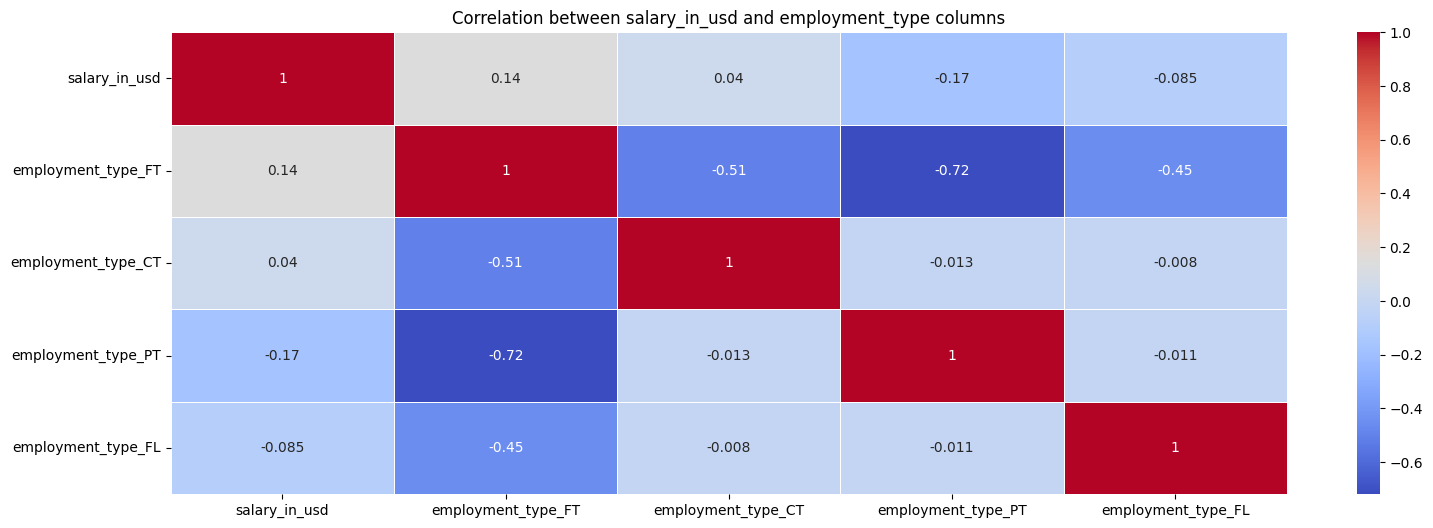

In [21]:
# 1. Выбираем все столбцы, начинающиеся с 'employee_residence_'
employment_type_columns = [col for col in df.columns if col.startswith('employment_type_')]
# 2. Добавляем 'salary_in_usd' к выбранным столбцам
columns_of_interest = ['salary_in_usd'] + employment_type_columns
# 3. Строим тепловую карту корреляций только для этих столбцов
plt.figure(figsize=(18, 6))
sns.heatmap(df[columns_of_interest].corr(method = 'spearman'), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation between salary_in_usd and employment_type columns')
plt.show()

## Промежуточные выводы

Не выявлено связи между employment_type_ и salary_in_usd

## Кодирование

дальше по-порядку идет job-title - признаков у этой категрии много и я не думаю что есть смысл кодировать признаки которые встречаются в наборе всего по нескольку раз - поэтому предлагаю отобрать 15 наиболее повторяющихся остальные поместить в категорию others а далее воспользоваться Binary_Encoding
Надеюсь это более или менее нормальный подход. Поехали!

In [22]:
# 1. Найдём 10-15 самых частых значений
top_n = 15
top_titles = df['job_title'].value_counts().index[:top_n]
# 2. Преобразуем все остальные в 'other'
df['job_title'] = df['job_title'].apply(lambda x: x if x in top_titles else 'other')

In [23]:
df['job_title'].value_counts()
# получилось что в категорию others входит 97 случаев. и она если так можно сказать массивнее многих остальных групп. не знаю на сколько это правильно. учитывая что среди непопулярных значений много вакансий со слвами head / lead / Principal /arhitect и все они вошли в группу others. тут есть выбор или бинарно кодировать все или сократить количетсво кодируемых значений общей группой - так как я сделал. честно я не могу оценить как это может повлиять на модель но что-то нужно выбрать. Я думаю имеет смысл протестировать модель с двумя этими походами. но так как нам ничего тестировать не надо для данной работы я выбираю объединение редких значений в общую группу.

job_title
Data Scientist                130
Data Engineer                 121
other                          97
Data Analyst                   82
Machine Learning Engineer      39
Research Scientist             16
Data Science Manager           12
Data Architect                 11
Machine Learning Scientist      8
Big Data Engineer               8
Data Science Consultant         7
Director of Data Science        7
AI Scientist                    7
Principal Data Scientist        7
Data Analytics Manager          7
ML Engineer                     6
Name: count, dtype: int64

переходим к бинарному кодированию

In [24]:
# 3. Применяем Binary Encoding
binary_encoder = ce.BinaryEncoder(cols=['job_title'])
job_title_bin = binary_encoder.fit_transform(df[['job_title']])

# 4. Извлекаем имена закодированных категорий для job_title
binary_feature_names = binary_encoder.get_feature_names_out(['job_title'])

# 5. Переименовываем закодированные колонки
job_title_bin.columns = binary_feature_names

# 6 копируем в отдельную переменную наш датафрейм
binary_encoded_df = df.copy()
# 7. Объединяем DataFrame с закодированными колонками
binary_encoded_df = pd.concat([binary_encoded_df, job_title_bin], axis=1)
binary_encoded_df

,work_year,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,experience_level_encoded,employment_type_FT,employment_type_CT,employment_type_PT,employment_type_FL,job_title_0,job_title_1,job_title_2,job_title_3,job_title_4
0,2020,Data Scientist,79833,DE,0,DE,L,2,1,0,0,0,0,0,0,0,1
1,2020,Machine Learning Scientist,260000,JP,0,JP,S,3,1,0,0,0,0,0,0,1,0
2,2020,Big Data Engineer,109024,GB,50,GB,M,3,1,0,0,0,0,0,0,1,1
3,2020,other,20000,HN,0,HN,S,2,1,0,0,0,0,0,1,0,0
4,2020,Machine Learning Engineer,150000,US,50,US,L,3,1,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,2022,Data Engineer,154000,US,100,US,M,3,1,0,0,0,0,0,1,1,1
603,2022,Data Engineer,126000,US,100,US,M,3,1,0,0,0,0,0,1,1,1
604,2022,Data Analyst,129000,US,0,US,M,3,1,0,0,0,0,0,1,1,0
605,2022,Data Analyst,150000,US,100,US,M,3,1,0,0,0,0,0,1,1,0


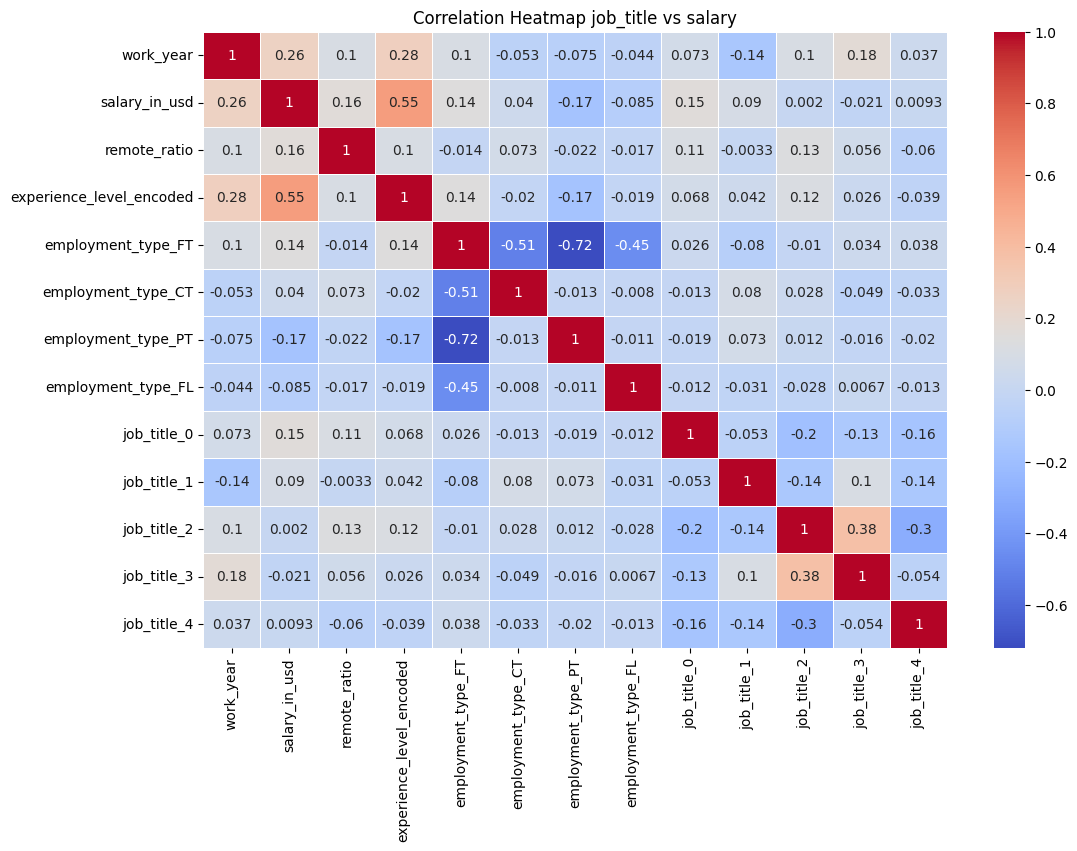

In [25]:
# Построим тепловую карту корреляций
plt.figure(figsize=(12, 8))
sns.heatmap(binary_encoded_df.corr(numeric_only=True, method = 'spearman'), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap job_title vs salary')
plt.show()

на этапе когда я посмотрел на результаты бинарного кодирования - мне стало ясно что у меня нет идей как на матрице корреляций вычислять влияние закодированных в Байнари Энкодинг данных на столбец salary_in_usd. ведь каждый столбец это всего лишь часть закодированного названия должности. поискал
информацию в интернете и честно говоря ничего толкового не нашел. так что видимо возвращаемся на наг назад - отменяем Байнари энкодинг, сокращаем количество групп до 9 + others и делаем One Hot хоть это и идет в разре с рекомендациями в плане того что категорий больше 5 - лучшего решенгия  я не нашел


значит возвращаемся на шаг назад и смотрим предывдущую версию df

In [26]:
df
# все отлично переходим к сттратегии OneHot Encoding c 15 категориями

,work_year,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,experience_level_encoded,employment_type_FT,employment_type_CT,employment_type_PT,employment_type_FL
0,2020,Data Scientist,79833,DE,0,DE,L,2,1,0,0,0
1,2020,Machine Learning Scientist,260000,JP,0,JP,S,3,1,0,0,0
2,2020,Big Data Engineer,109024,GB,50,GB,M,3,1,0,0,0
3,2020,other,20000,HN,0,HN,S,2,1,0,0,0
4,2020,Machine Learning Engineer,150000,US,50,US,L,3,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
602,2022,Data Engineer,154000,US,100,US,M,3,1,0,0,0
603,2022,Data Engineer,126000,US,100,US,M,3,1,0,0,0
604,2022,Data Analyst,129000,US,0,US,M,3,1,0,0,0
605,2022,Data Analyst,150000,US,100,US,M,3,1,0,0,0


In [27]:
encoder = ce.OneHotEncoder(cols=['job_title'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(df['job_title'])
df = pd.concat([df, type_bin], axis=1)

# Удаляем оригинальный столбец job_title
df = df.drop(columns=['job_title'])
# проверяем все ли в порядке
df
#  полный порядок столбец закодирован

,work_year,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,experience_level_encoded,employment_type_FT,employment_type_CT,employment_type_PT,...,job_title_Data Engineer,job_title_Data Science Consultant,job_title_Director of Data Science,job_title_Research Scientist,job_title_ML Engineer,job_title_AI Scientist,job_title_Principal Data Scientist,job_title_Data Science Manager,job_title_Data Analytics Manager,job_title_Data Architect
0,2020,79833,DE,0,DE,L,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020,260000,JP,0,JP,S,3,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2020,109024,GB,50,GB,M,3,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020,20000,HN,0,HN,S,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2020,150000,US,50,US,L,3,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,2022,154000,US,100,US,M,3,1,0,0,...,1,0,0,0,0,0,0,0,0,0
603,2022,126000,US,100,US,M,3,1,0,0,...,1,0,0,0,0,0,0,0,0,0
604,2022,129000,US,0,US,M,3,1,0,0,...,0,0,0,0,0,0,0,0,0,0
605,2022,150000,US,100,US,M,3,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Визуализация

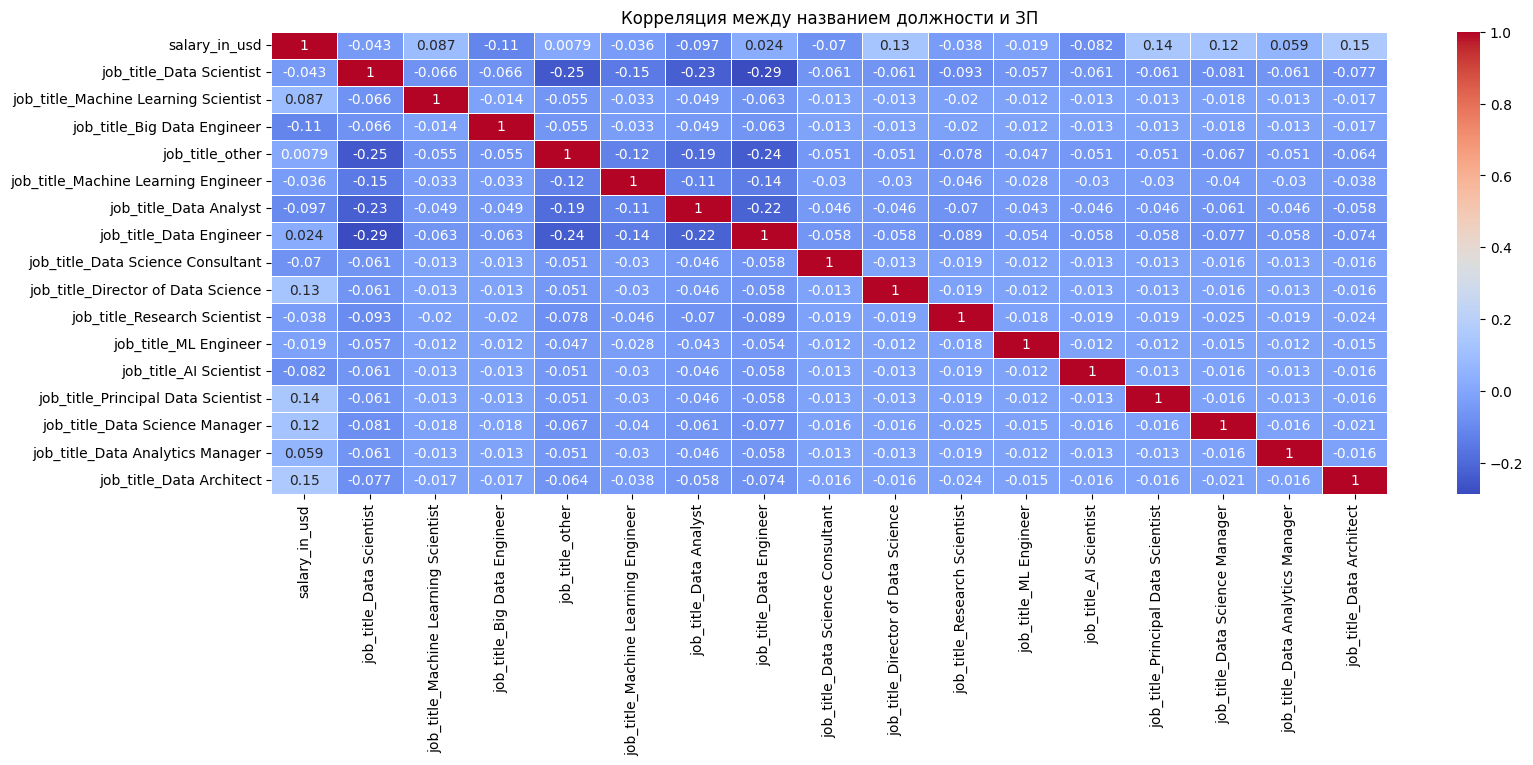

In [28]:
# проверяем как будет выглядеть тепловая матрица - промежуточный результат
# Построим тепловую карту корреляций
job_title_columns = [col for col in df.columns if col.startswith('job_title_')]
# 2. Добавляем 'salary_in_usd' к выбранным столбцам
columns_of_interest = ['salary_in_usd'] + job_title_columns
# 3. Строим тепловую карту корреляций только для этих столбцов
plt.figure(figsize=(18, 6))
sns.heatmap(df[columns_of_interest].corr(method = 'spearman'), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Корреляция между названием должности и ЗП')
plt.show()

## Промежуточные выводы
тут мы можно сделать выводы что не выявлено связи между названием долдности и ЗП, что в целом весьма закономерно, так как в плане названия должностей нет никакой стандартизации и все называют свои должности как хотят, поэтому вполне вероятно что вариации на тему data since / machine learning  особо не влияют на зп. 


## Кодирование

теперь на очереди столбец employee_residence как мы видим у нас досттаточно много уникальный значений, думаю что можно для начала взять топ 9 стран и десятым пунктом добавить категорию other где мы объединим все остальные страны. потом опыть внесем изменения в тепловую матрицу корреляций и посмотрим что получилось

In [29]:
# 1. Найдём 14 частых значений
top_n = 14
top_employee_residence = df['employee_residence'].value_counts().index[:top_n]
# 2. Преобразуем все остальные в 'other'
df['employee_residence'] = df['employee_residence'].apply(lambda x: x if x in top_employee_residence else 'other')
# проверяем что все получилось как запланировано
df['employee_residence'].value_counts()


employee_residence
US       295
other     67
GB        43
IN        30
CA        27
DE        24
FR        18
ES        15
GR        12
JP         7
PK         6
PT         6
BR         6
NL         5
PL         4
Name: count, dtype: int64

далее деаем One-Hot Encoding

In [30]:
encoder = ce.OneHotEncoder(cols=['employee_residence'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(df['employee_residence'])
df = pd.concat([df, type_bin], axis=1)

# Удаляем оригинальный столбец job_title
df = df.drop(columns=['employee_residence'])
# проверяем все ли в порядке
df
#  полный порядок столбец закодирован

,work_year,salary_in_usd,remote_ratio,company_location,company_size,experience_level_encoded,employment_type_FT,employment_type_CT,employment_type_PT,employment_type_FL,...,employee_residence_FR,employee_residence_IN,employee_residence_PK,employee_residence_PL,employee_residence_PT,employee_residence_GR,employee_residence_NL,employee_residence_CA,employee_residence_ES,employee_residence_BR
0,2020,79833,0,DE,L,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020,260000,0,JP,S,3,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2020,109024,50,GB,M,3,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020,20000,0,HN,S,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2020,150000,50,US,L,3,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,2022,154000,100,US,M,3,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
603,2022,126000,100,US,M,3,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
604,2022,129000,0,US,M,3,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
605,2022,150000,100,US,M,3,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Визуализация

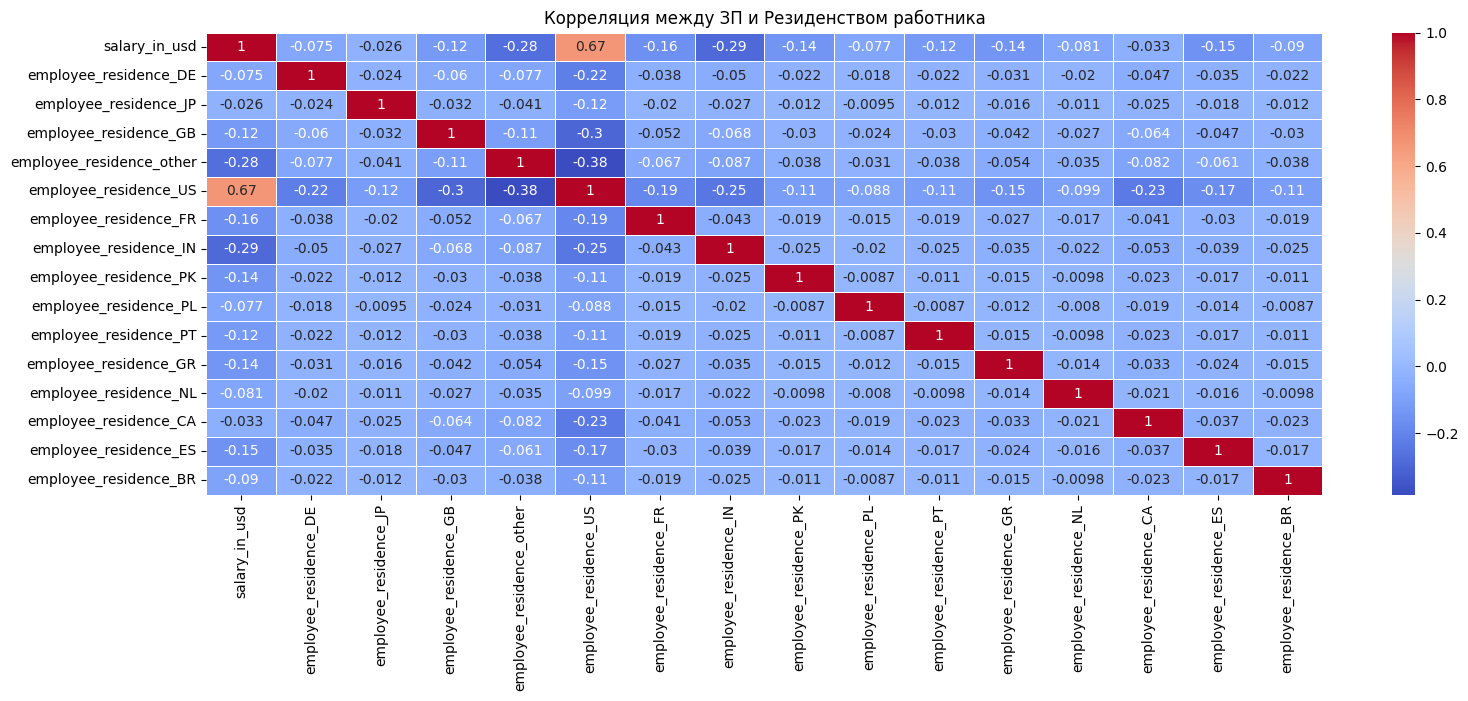

In [31]:
# 1. Выбираем все столбцы, начинающиеся с 'employee_residence_'
employee_res_columns = [col for col in df.columns if col.startswith('employee_residence_')]
# 2. Добавляем 'salary_in_usd' к выбранным столбцам
columns_of_interest = ['salary_in_usd'] + employee_res_columns
# 3. Строим тепловую карту корреляций только для этих столбцов
plt.figure(figsize=(18, 6))
sns.heatmap(df[columns_of_interest].corr(method = 'spearman'), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Корреляция между ЗП и Резиденством работника')
plt.show()

интересно - мы можем видеть положительный коэфициент для Соединненых Штатов - 0.67 (средняя связь - по верхней границе) и отрицательный для Индии - -0.29 (слабая связь) и для остального мира - -0.28
В целом результат весьма ожидаемый в области IT в целом. 

## Промежуточные выводы

Страна резиденства может влиять на зп. Если работник из США то вероятнее он получает более высокую зп. работники из индии и других стран имеют вероятность получать меньшую зп 

## Кодирование

следующий столбец это remote_ratio - не думаю что молжно применить Ordinal Encoding , будем применять как и в прошлом One-Hot Encoding

In [32]:
encoder = ce.OneHotEncoder(cols=['remote_ratio'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(df['remote_ratio'])
df = pd.concat([df, type_bin], axis=1)

# Удаляем оригинальный столбец job_title
df = df.drop(columns=['remote_ratio'])
# проверяем все ли в порядке
df
#  полный порядок столбец закодирован

,work_year,salary_in_usd,company_location,company_size,experience_level_encoded,employment_type_FT,employment_type_CT,employment_type_PT,employment_type_FL,job_title_Data Scientist,...,employee_residence_PL,employee_residence_PT,employee_residence_GR,employee_residence_NL,employee_residence_CA,employee_residence_ES,employee_residence_BR,remote_ratio_0.0,remote_ratio_50.0,remote_ratio_100.0
0,2020,79833,DE,L,2,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,2020,260000,JP,S,3,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,2020,109024,GB,M,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,2020,20000,HN,S,2,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,2020,150000,US,L,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,2022,154000,US,M,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
603,2022,126000,US,M,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
604,2022,129000,US,M,3,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
605,2022,150000,US,M,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Визуализация

делаем срез только для новых колонок что бы лучше видеть карту

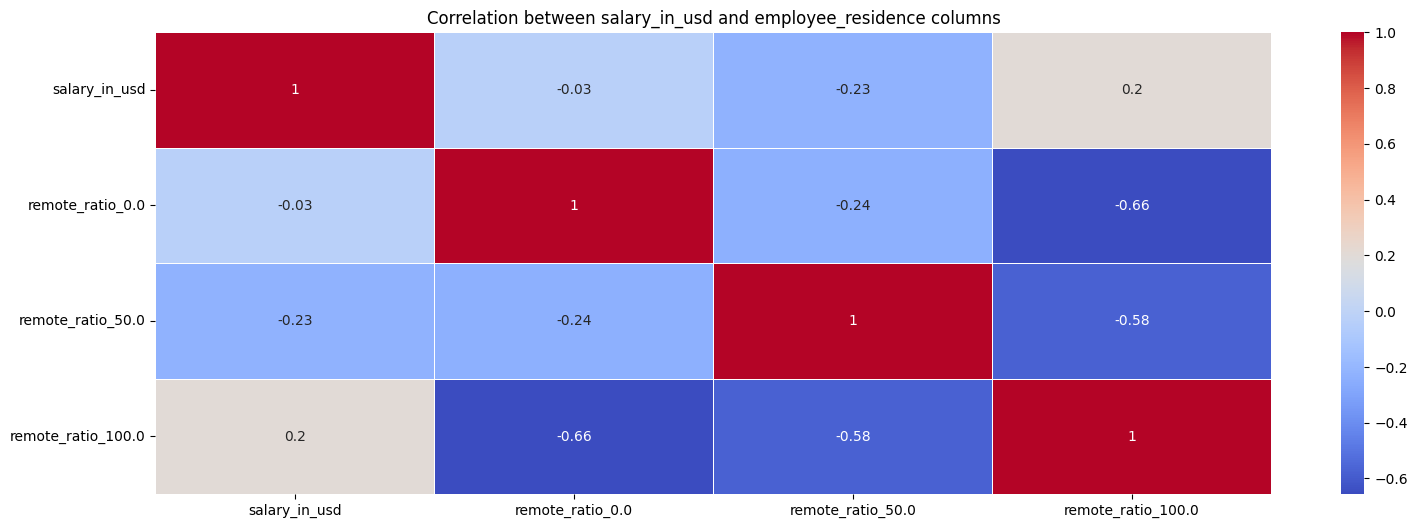

In [33]:
# 1. Выбираем все столбцы, начинающиеся с 'remote_ratio'
remote_ratio_columns = [col for col in df.columns if col.startswith('remote_ratio_')]
# 2. Добавляем 'salary_in_usd' к выбранным столбцам
columns_of_interest = ['salary_in_usd'] + remote_ratio_columns
# 3. Строим тепловую карту корреляций только для этих столбцов
plt.figure(figsize=(18, 6))
sns.heatmap(df[columns_of_interest].corr(method = 'spearman'), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation between salary_in_usd and employee_residence columns')
plt.show()


## Промежуточные выводы
какой-либо ярко выраженной корреляции не наблюдается

## Кодирование

следующая колонка company_location -все тоже самое с One-Hot Encoding

In [34]:
# 1. Найдём 14 частых значений
top_n = 14
top_company_location = df['company_location'].value_counts().index[:top_n]
# 2. Преобразуем все остальные в 'other'
df['company_location'] = df['company_location'].apply(lambda x: x if x in top_company_location else 'other')
# проверяем что все получилось как запланировано
df['company_location'].value_counts()

company_location
US       318
other     58
GB        46
CA        28
DE        27
IN        24
FR        15
ES        14
GR        10
JP         6
NL         4
AT         4
PT         4
PL         4
LU         3
Name: count, dtype: int64

далее деаем One-Hot Encoding

In [35]:
encoder = ce.OneHotEncoder(cols=['company_location'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(df['company_location'])
df = pd.concat([df, type_bin], axis=1)

# Удаляем оригинальный столбец job_title
df = df.drop(columns=['company_location'])
# проверяем все ли в порядке
df
#  полный порядок столбец закодирован

,work_year,salary_in_usd,company_size,experience_level_encoded,employment_type_FT,employment_type_CT,employment_type_PT,employment_type_FL,job_title_Data Scientist,job_title_Machine Learning Scientist,...,company_location_FR,company_location_IN,company_location_GR,company_location_NL,company_location_CA,company_location_AT,company_location_ES,company_location_PT,company_location_LU,company_location_PL
0,2020,79833,L,2,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2020,260000,S,3,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2020,109024,M,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020,20000,S,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2020,150000,L,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,2022,154000,M,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
603,2022,126000,M,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
604,2022,129000,M,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
605,2022,150000,M,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Визуализация

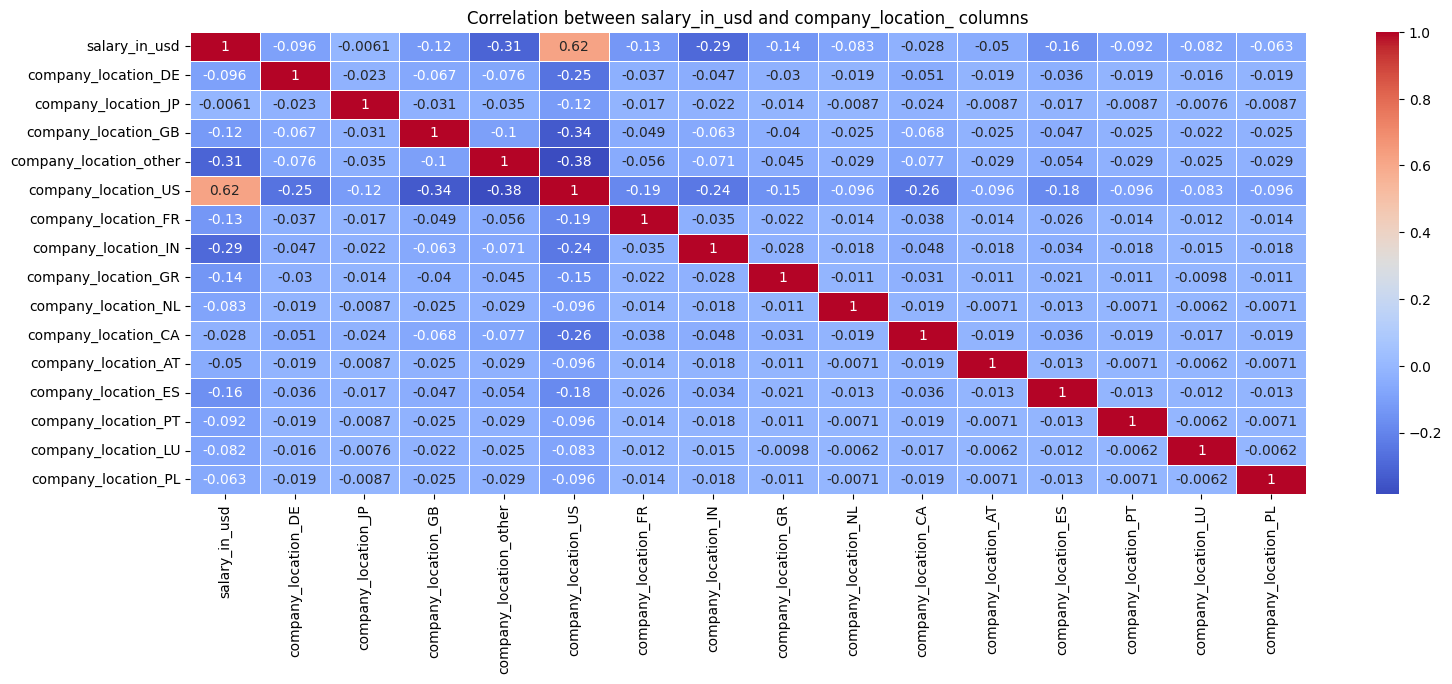

In [36]:
# 1. Выбираем все столбцы, начинающиеся с 'company_location_'
company_location_columns = [col for col in df.columns if col.startswith('company_location_')]
# 2. Добавляем 'salary_in_usd' к выбранным столбцам
columns_of_interest = ['salary_in_usd'] + company_location_columns
# 3. Строим тепловую карту корреляций только для этих столбцов
plt.figure(figsize=(18, 6))
sns.heatmap(df[columns_of_interest].corr(method = 'spearman' ), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation between salary_in_usd and company_location_ columns')
plt.show()

## Промежуточные выводы
В целом без сюрпризов - ситуация похожа на ситкацию с резидентством. средняя(почти по верхней границе) корреляционная связь замечена между компанииями из США и ЗП  очень млабая отрицательная у Индии и остальной части 

## Кодирование

остается теперь только размер компании - поступим схожим образом


In [37]:
encoder = ce.OneHotEncoder(cols=['company_size'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(df['company_size'])
df = pd.concat([df, type_bin], axis=1)

# Удаляем оригинальный столбец job_title
df = df.drop(columns=['company_size'])
# проверяем все ли в порядке
df
#  полный порядок столбец закодирован

,work_year,salary_in_usd,experience_level_encoded,employment_type_FT,employment_type_CT,employment_type_PT,employment_type_FL,job_title_Data Scientist,job_title_Machine Learning Scientist,job_title_Big Data Engineer,...,company_location_NL,company_location_CA,company_location_AT,company_location_ES,company_location_PT,company_location_LU,company_location_PL,company_size_L,company_size_S,company_size_M
0,2020,79833,2,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,2020,260000,3,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,2020,109024,3,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,2020,20000,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,2020,150000,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,2022,154000,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
603,2022,126000,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
604,2022,129000,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
605,2022,150000,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Визуализация

делаем срез только для новых колонок что бы лучше видеть карту

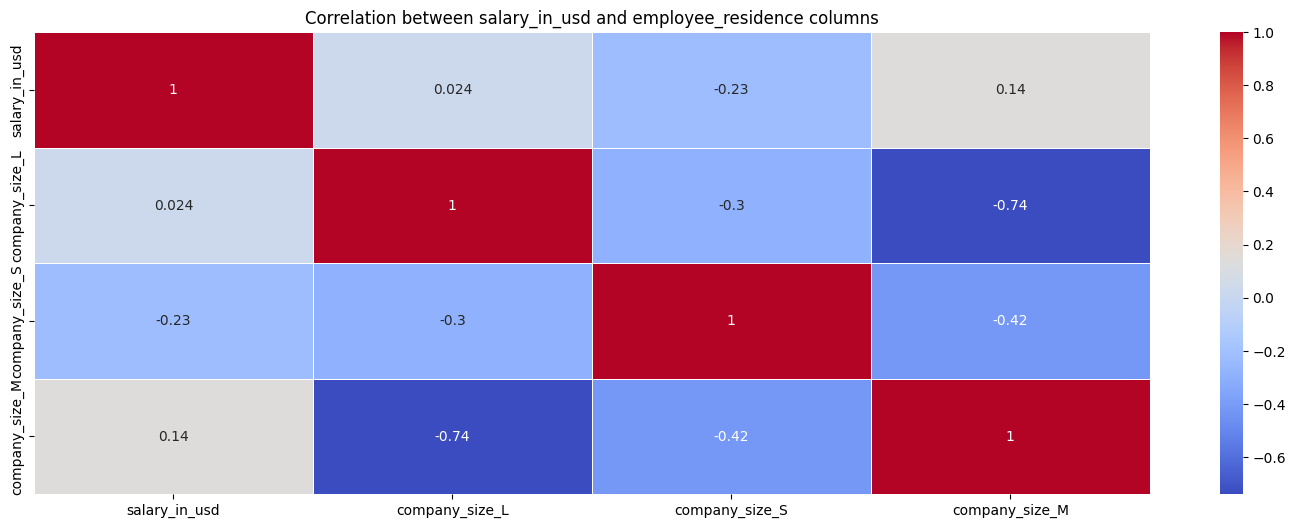

In [38]:
# 1. Выбираем все столбцы, начинающиеся с 'company_size'
company_size_columns = [col for col in df.columns if col.startswith('company_size_')]
# 2. Добавляем 'salary_in_usd' к выбранным столбцам
columns_of_interest = ['salary_in_usd'] + company_size_columns
# 3. Строим тепловую карту корреляций только для этих столбцов
plt.figure(figsize=(18, 6))
sns.heatmap(df[columns_of_interest].corr(method = 'spearman'), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation between salary_in_usd and employee_residence columns')
plt.show()

## Промежуточные выводы
 наблюдается либо очень слабая связь между размером компании и зп либо ее отсутсвие. Интресно что чем компания больше тем больше коэфициент корреляции , но по -моему это не очень значимо

## Краткие выводы по результатам разведывательного анализа

ТЕПЕРЬ Вынесем все наши промежуточные выводы сюда:
- большая часть работников из США 

- большая часть компаний сосредоточена в США

- большая часть рабоает удаленно

- уровень экспертности имеет среднюю положительную корреляцию с зп.

- не выявлено связи между employment_type_ и salary_in_usd

- страна резиденства может влиять на зп. Если работник из США то вероятнее он получает более высокую зп. работники из индии и других стран имеют вероятность получать меньшую зп 

- какой-либо ярко выраженной корреляции remote_ratio и  salary_in_usd не наблюдается

- company_location и salary_in_usd  средняя(почти по верхней границе) положительная корреляционная связь замечена между компанииями из США и ЗП  очень млабая отрицательная у Индии и остальной части 

- company_size и salary_in_usd наблюдается либо очень слабая связь между размером компании и зп либо ее отсутсвие. Интресно что чем компания больше тем больше коэфициент корреляции , но по -моему это не очень значимо

## Предварительный ответ на вопрос какие факторы из нашегодатасэта влияют на заработную плату:

Теперь мы можем ответить на вопрос какие факторы из нашегодатасэта влияют на заработную плату:
- 1) уровень экспертности от EN MI SE EX  влияет на заработную плату. коэфициент корреляции 0.55
- 2) Страна резиденства влияет на заработную плату.  мы можем видеть положительный коэфициент для Соединненых Штатов - 0.67 (средняя связь - по верхней границе) и отрицательный для Индии - -0.29 (слабая связь) и для остального мира - -0.28
- 3) Страна в которой расположена компания влияет на заработную плату. Ситуация похожа на ситкацию с резидентством. средняя(почти по верхней границе) корреляционная связь замечена между компанииями из США и ЗП  очень млабая отрицательная у Индии и остальной части 

## Переход к ответам на основные вопросы исследования и статистическим тестам

переходим к ответам на следующие вопросы:
- Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
- Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
- Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
- Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

##  Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?



все таки вопрос сформулирован четко - зарплата у специалистов Data Scientists - соответсвтенно  предалагаю сначала отфильтровать всех специалистов с конкретно этой профессией

In [39]:
# Фильтруем данные для Data Scientist
df_data_scientist = df[df['job_title_Data Scientist'] == 1]
df_data_scientist
# Вычисляем среднюю зарплату по годам
salary_trend = df_data_scientist.groupby('work_year')['salary_in_usd'].mean().reset_index()
# Выводим результат
print(salary_trend)

   work_year  salary_in_usd
0       2020   85970.523810
1       2021   70215.772727
2       2022  131366.938462


## Визуализация

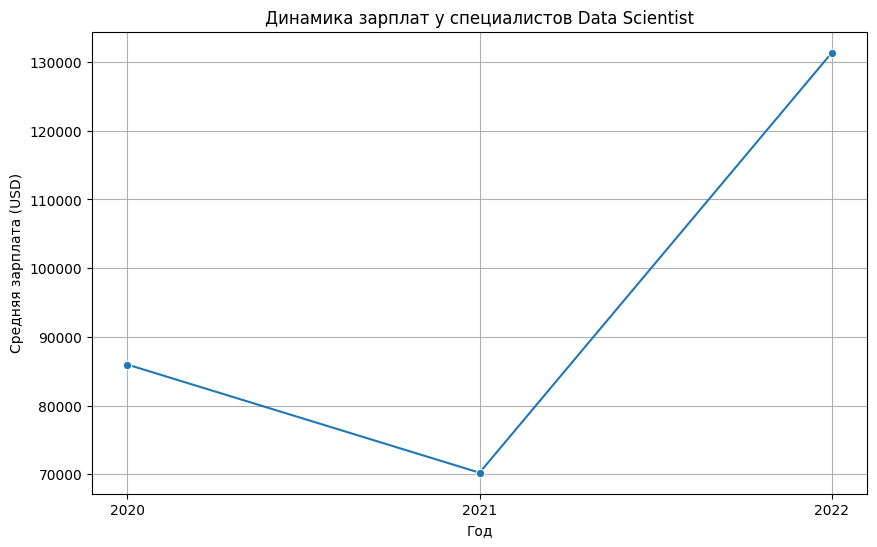

In [40]:
# Визуализируем тренд изменения зарплаты по годам
plt.figure(figsize=(10, 6))
sns.lineplot(x='work_year', y='salary_in_usd', data=salary_trend, marker='o')
plt.xticks(salary_trend['work_year'].unique())
plt.title('Динамика зарплат у специалистов Data Scientist')
plt.xlabel('Год')
plt.ylabel('Средняя зарплата (USD)')
plt.grid(True)
plt.show()

Теперь сформулируем нулевую и альтернативную гипотезы, выберем и проведем статистический тест , уровень значимости - альфа - установим на 5%.

**Нулевая гипотеза        - Средние зарплаты специалистов Data Scientist не изменяются с течением времени (от года к году).**

**Альтернативная гипотеза - Средние зарплаты специалистов Data Scientist изменяются с течением времени.**

Так как год все же ближе к категориальному признаку так как имеет всего 3 уникальных значения и зарплата числовой с НЕ нормальным распределением - то обратимся к непараметрическим тестам для 3 групп(3 года) и по нашей схеме это будет критерий Краскела-Уоллиса. 


Поехали!

In [41]:
alpha = 0.05
_, p  = kruskal(
    df_data_scientist[df_data_scientist['work_year'] == 2020]['salary_in_usd'],
    df_data_scientist[df_data_scientist['work_year'] == 2021]['salary_in_usd'],
    df_data_scientist[df_data_scientist['work_year'] == 2022]['salary_in_usd']
)
p

if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


Соответсвенно мы можем сделать выводы что существует статистически значимое различие заработных плат.

Но проблема в том что отвечая строго на вопрос - - Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

самый точный ответ в данной ситуации будет - Нет Ежегодного роста заработных плат не наблюдается.
Так как в 2021 году мы наблюдаем снижение относительно 2020 а 2022 рост относительно 2021. так что если брать все три года - то точно нет факта ежегодного статистически значимого увеличения от года к году, но в целом за три года произошол статистически значимый рост заработной платы.

## ОТВЕТ: Нет Ежегодного роста заработных плат не наблюдается. Так как в 2021 году мы наблюдаем снижение относительно 2020 а 2022 рост относительно 2021. так что если брать все три года - то точно нет факта ежегодного статистически значимого увеличения от года к году так как в 2021 году было установлено снижение, но в целом за три года произошол статистически значимый рост заработной платы.

## - Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

**Нулевая гипотеза        - зарплаты между двумя группами (Data Scientist и Data Engineer) распределены одинаково, и между ними нет статистически значимых различий.**

**Альтернативная гипотеза - зарплаты между двумя группами (Data Scientist и Data Engineer) распределены не одинаково, и между ними есть статистически значимые различия**

In [42]:
# Фильтруем записи за 2022 год
year_2022 = df[df['work_year'] == 2022]
# выделяем 2 независимые группы
data_scientist_salary_2022 = year_2022[year_2022['job_title_Data Scientist'] == 1]['salary_in_usd']
data_engineer_salary_2022 = year_2022[year_2022['job_title_Data Engineer'] == 1]['salary_in_usd']
# теперь посмотрим на средние значения 
print(f"Data Scientist (2022): Средняя зарплата = {data_scientist_salary_2022.mean()}, Медиана = {data_scientist_salary_2022.median()}, Стандартное отклонение = {data_scientist_salary_2022.std()}")
print(f"Data Engineer (2022): Средняя зарплата = {data_engineer_salary_2022.mean()}, Медиана = {data_engineer_salary_2022.median()}, Стандартное отклонение = {data_engineer_salary_2022.std()}")

Data Scientist (2022): Средняя зарплата = 131366.93846153846, Медиана = 135000.0, Стандартное отклонение = 55785.24319989251
Data Engineer (2022): Средняя зарплата = 124651.78481012658, Медиана = 115000.0, Стандартное отклонение = 57846.8411469794


## Визуализация

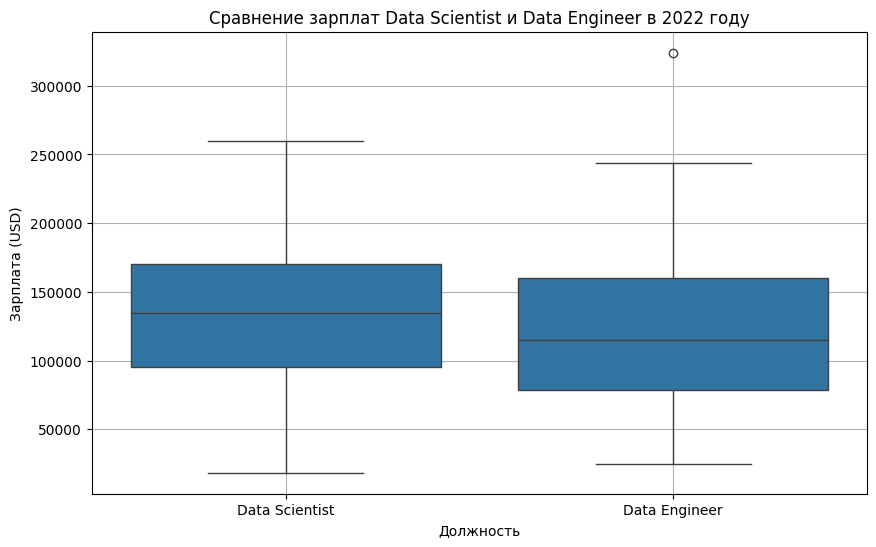

In [43]:
# посмотрим на графики
#  для визуализации построим датафрйм
salary_data = pd.DataFrame({
    'salary_in_usd': pd.concat([data_scientist_salary_2022, data_engineer_salary_2022]),
    'job_title': ['Data Scientist'] * len(data_scientist_salary_2022) + ['Data Engineer'] * len(data_engineer_salary_2022)
})
# Построим boxplot для сравнения зарплат Data Scientist и Data Engineer в 2022 году
plt.figure(figsize=(10, 6))
sns.boxplot(x='job_title', y='salary_in_usd', data=salary_data)
plt.title('Сравнение зарплат Data Scientist и Data Engineer в 2022 году')
plt.xlabel('Должность')
plt.ylabel('Зарплата (USD)')
plt.grid(True)
plt.show()




Визуально различие не большое , но проверим его значимость с помощью тестов.
соответсвенно у нас есть 2 независимые группы. я думаю что распределение по за остается не нормальным но так как выборка изменилась давайте еще раз проверим это что бы наверняка

## Проверка распределения

In [44]:
# Проверка нормальности зарплат
shapiro_test_data_scientist = shapiro(data_scientist_salary_2022)
shapiro_test_data_engineer = shapiro(data_engineer_salary_2022)

print(f"Shapiro-Wilk test для Data Scientist: p-value = {shapiro_test_data_scientist.pvalue}")
print(f"Shapiro-Wilk test для Data Engineer: p-value = {shapiro_test_data_engineer.pvalue}")

Shapiro-Wilk test для Data Scientist: p-value = 0.6761812341970217
Shapiro-Wilk test для Data Engineer: p-value = 0.006595437862877021


## Статистический тест

соответсвенно как минимум у Data Engineer мы что вынуждены отвергнуть нулевую гипотезу о том что распределение нормальное а это значит что придется выбрать U критерий Манна Уитни для тестов

In [45]:
_,p = mannwhitneyu(data_scientist_salary_2022, data_engineer_salary_2022)
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))



p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


## ОТВЕТ: Зарплаты между двумя группами (Data Scientist и Data Engineer) распределены одинаково, и между ними нет статистически значимых различий.

## -Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

**Нулевая гипотеза        - Средние зарплаты специалистов Data Scientist не изменяются в зависимости от размера компаний.**

**Альтернативная гипотеза - Средние зарплаты специалистов Data Scientist  изменяются в зависимости от размера компаний.**

In [46]:
# оставляем только data scientits
data_scientists = df[df['job_title_Data Scientist'] == 1]
# фильтруем компании по размерау
small_company_salary = data_scientists[data_scientists['company_size_S'] ==1]['salary_in_usd']
medium_company_salary = data_scientists[data_scientists['company_size_M'] ==1]['salary_in_usd']
large_company_salary = data_scientists[data_scientists['company_size_L'] ==1]['salary_in_usd']
# теперь посмотрим на средние значения 
print(f"Маленькие Компании: Средняя зарплата = {small_company_salary.mean()}, Медиана = {small_company_salary.median()}, Стандартное отклонение = {small_company_salary.std()}")
print(f"Средние Компании: Средняя зарплата = {medium_company_salary.mean()}, Медиана = {medium_company_salary.median()}, Стандартное отклонение = {medium_company_salary.std()}")
print(f"Крупные Компании: Средняя зарплата = {large_company_salary.mean()}, Медиана = {large_company_salary.median()}, Стандартное отклонение = {large_company_salary.std()}")

Маленькие Компании: Средняя зарплата = 51925.76190476191, Медиана = 49268.0, Стандартное отклонение = 33216.289637623224
Средние Компании: Средняя зарплата = 120080.57575757576, Медиана = 119529.5, Стандартное отклонение = 56347.78686229645
Крупные Компании: Средняя зарплата = 102743.41860465116, Медиана = 90734.0, Стандартное отклонение = 73254.0969500236


## Визуализация

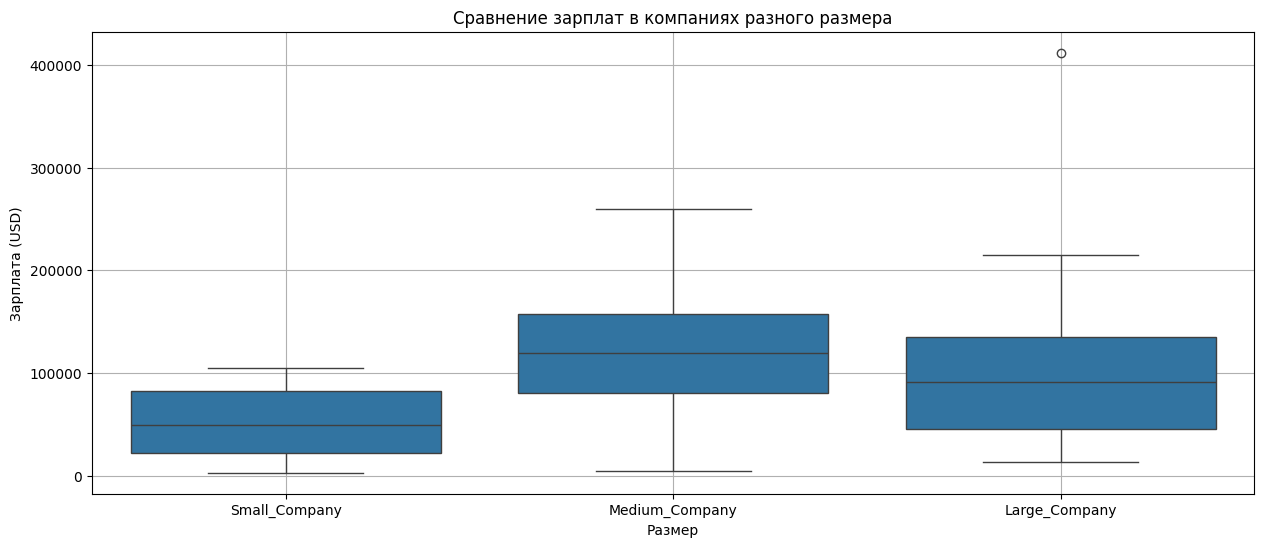

In [47]:
# посмотрим на графики
#  для визуализации построим датафрйм
salary_data = pd.DataFrame({
    'salary_in_usd': pd.concat([small_company_salary, medium_company_salary,large_company_salary]),
    'company_size': ['Small_Company'] * len(small_company_salary) + ['Medium_Company'] * len(medium_company_salary) + ['Large_Company'] * len(large_company_salary)
})

# Построим boxplot для сравнения зарплат по размерам компаний
plt.figure(figsize=(15, 6))
sns.boxplot(x='company_size', y='salary_in_usd', data=salary_data)
plt.title('Сравнение зарплат в компаниях разного размера')
plt.xlabel('Размер')
plt.ylabel('Зарплата (USD)')
plt.grid(True)
plt.show()


## Статистические тесты

Сейчас будем тестировать.
Проверем как распределяется ЗП в трех группах тестом Шапиро

In [48]:
shapiro_test_small = shapiro(small_company_salary)
shapiro_test_medium = shapiro(medium_company_salary)
shapiro_test_large = shapiro(large_company_salary)


print(f"Shapiro-Wilk test для Small Companies: p-value = {shapiro_test_small.pvalue}")
print(f"Shapiro-Wilk test для Medium Companies: p-value = {shapiro_test_medium.pvalue}")
print(f"Shapiro-Wilk test для Large Companies: p-value = {shapiro_test_large.pvalue}")

Shapiro-Wilk test для Small Companies: p-value = 0.18902802506301086
Shapiro-Wilk test для Medium Companies: p-value = 0.89650723543162
Shapiro-Wilk test для Large Companies: p-value = 3.8677400886091944e-05


мы видим что в Large Companies распределение не нормальное, группы не зависимы, значит выбираем критерий Краскелла Уолиса

In [49]:
alpha = 0.05
_, p  = kruskal(
    small_company_salary,
    medium_company_salary,
    large_company_salary
)
print(p)

if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

1.149761419785145e-05
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


мы выфснили что Средние зарплаты специалистов Data Scientist  изменяются в зависимости от размера компаний.

но вопрос как? можем ли мы утвержать что то что мы видим на графике - например то что в круаных компаниях зарплаты выше чем в маленьких? 

А в Средних компаниях зарплата выше чем в больших?

Я думаю что мы раз мы выяснили то что есть статистически значимые различия - можно немного углубиться и дать ответы на 2 дополнительных вопроса.

А заодно этим самым дополнительным исследованием я выполню задание номер 4 под названием дополнительное исследование.

1) в средних компаниях зар. плата больше чем зарплата в больших компаниях?

2) в больших компаниях зар. плата больше чем зарплата в маленьких компаниях?



## ПРОВЕРКА ДОПОЛНИТЕЛЬНОЙ ГИПОТЕЗЫ

In [50]:
# 1) в средних компаниях зар плата больше чем зарплата в больших компаниях?
# Нулевая гипотеза:             Медианы зарплат Data Scientist в средних и больших компаниях одинаковы.
# Альтернативная гипотеза:      Медианы зарплат Data Scientist в средних и больших компаниях различаются.
u_test_medium_vs_large = mannwhitneyu(medium_company_salary, large_company_salary)
print(f"p-value для сравнения Средних и Больших компаний: {u_test_medium_vs_large.pvalue}")

# Интерпретация результатов
if u_test_medium_vs_large.pvalue < 0.05:
    print("Зарплаты в средних и больших компаниях статистически значимо различаются. Отвергаем нулевую гипотезу.")
else:
    print("Нет статистически значимых различий между зарплатами в средних и больших компаниях. Нулевая гипотеза не отвергается.")
# исходя из графика мы можем понять что отличаются они в сторону увеличения зп в средних компаниях.

p-value для сравнения Средних и Больших компаний: 0.04828692145062903
Зарплаты в средних и больших компаниях статистически значимо различаются. Отвергаем нулевую гипотезу.


In [51]:
# 2) в больших компаниях зар плата больше чем зарплата в маленьких компаниях?
# Нулевая гипотеза:             Медианы зарплат Data Scientist в больших и маленьких компаниях одинаковы.
# Альтернативная гипотеза:      Медианы зарплат Data Scientist в больших и маленьких компаниях различаются.

u_test_large_vs_small = mannwhitneyu(large_company_salary, small_company_salary)
print(f"p-value для сравнения Больших и Маленьких компаний: {u_test_large_vs_small.pvalue}")

# Интерпретация результатов
if u_test_large_vs_small.pvalue < 0.05:
    print("Зарплаты в больших и маленьких компаниях статистически значимо различаются. Отвергаем нулевую гипотезу.")
else:
    print("Нет статистически значимых различий между зарплатами в больших и маленьких компаниях. Нулевая гипотеза не отвергается.")
# соответственно из графика мы понимаем что в больших компаниях платят больше чем в маленьких

p-value для сравнения Больших и Маленьких компаний: 0.002612445174570143
Зарплаты в больших и маленьких компаниях статистически значимо различаются. Отвергаем нулевую гипотезу.




## ОТВЕТ:

Средние зарплаты специалистов Data Scientist  изменяются в зависимости от размера компаний.


## ДОПОЛНИТЕЛЬНЫЙ ВОПРОС-ИССЛЕДОВАНИЕ:

1) в средних компаниях зар плата больше чем зарплата в больших компаниях?

## ДОПОЛНИТЕЛЬНЫЙ ОТВЕТ: Зарплаты в средних и больших компаниях статистически значимо различаются. В средних компаниях заработная плата выше

## ДОПОЛНИТЕЛЬНЫЙ ВОПРОС-ИССЛЕДОВАНИЕ:

2) в больших компаниях зар плата больше чем зарплата в маленьких компаниях?

## ДОПОЛНИТЕЛЬНЫЙ ОТВЕТ:
Зарплаты в маленьких и больших компаниях статистически значимо различаются. В больших компаниях заработная плата выше.

## - Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

План ответа: Тут мы проверяем связь между категориальным признаком job_title и также категориальным признаком company_size, в данном случае нам могут помочь статистические тесты для категориальных признаков такие как Критерий Хи Квадрат. Поехали!

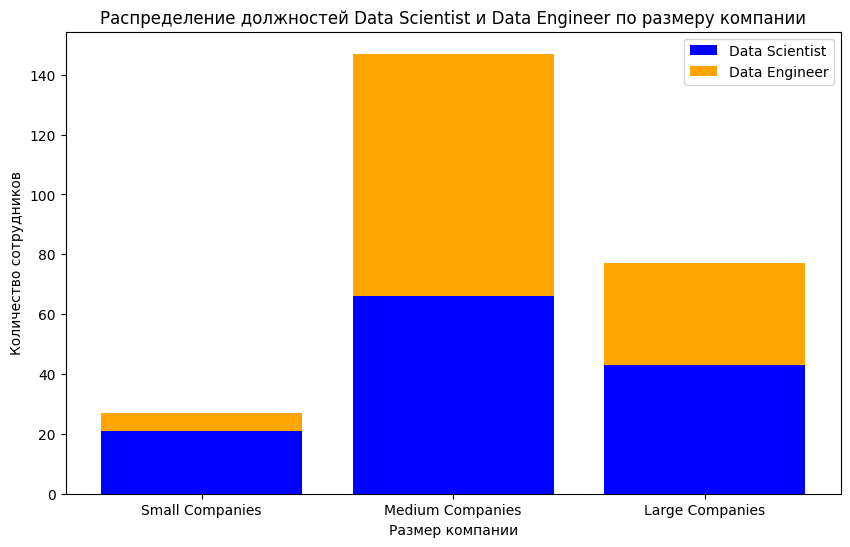

In [52]:
# Нулевая гипотеза:             Нет зависимости между наличием должностей Data Scientist и Data Engineer и размером компании.
# Альтернативная гипотеза:      Существует зависимость между наличием должностей Data Scientist и Data Engineer и размером компании.

# Фильтруем данные 
df_roles = df[(df['job_title_Data Scientist'] == 1) | (df['job_title_Data Engineer'] == 1)]
cross_table = pd.crosstab(
    [df_roles['job_title_Data Scientist'], df_roles['job_title_Data Engineer']],  
    [df_roles['company_size_S'], df_roles['company_size_M'], df_roles['company_size_L']]  
)
# Считаем количество Data Scientist и Data Engineer в каждой категории компаний
data_scientist_counts = [
    df_roles[df_roles['company_size_S'] == 1]['job_title_Data Scientist'].sum(),
    df_roles[df_roles['company_size_M'] == 1]['job_title_Data Scientist'].sum(),
    df_roles[df_roles['company_size_L'] == 1]['job_title_Data Scientist'].sum()
]

data_engineer_counts = [
    df_roles[df_roles['company_size_S'] == 1]['job_title_Data Engineer'].sum(),
    df_roles[df_roles['company_size_M'] == 1]['job_title_Data Engineer'].sum(),
    df_roles[df_roles['company_size_L'] == 1]['job_title_Data Engineer'].sum()
]

# Данные для визуализации
company_sizes = ['Small Companies', 'Medium Companies', 'Large Companies']

# Построение составной столбчатой диаграммы
plt.figure(figsize=(10, 6))
plt.bar(company_sizes, data_scientist_counts, label='Data Scientist', color='blue')
plt.bar(company_sizes, data_engineer_counts, bottom=data_scientist_counts, label='Data Engineer', color='orange')

# Добавление подписей и легенды
plt.title('Распределение должностей Data Scientist и Data Engineer по размеру компании')
plt.xlabel('Размер компании')
plt.ylabel('Количество сотрудников')
plt.legend()

# Отображение графика
plt.show()

In [53]:
# Применяем тест хи-квадрат к кросс-таблице
_, p, _, _ = chi2_contingency(cross_table)
alpha = 0.05
if p < alpha:
    print("Мы отвергаем нулевую гипотезу: существует зависимость между наличием должностей и размером компании.")
else:
    print("Нулевая гипотеза не отвергается: зависимости между наличием должностей и размером компании нет.")

Мы отвергаем нулевую гипотезу: существует зависимость между наличием должностей и размером компании.


2024-09-26 17:01:34,871 - INFO     - Executing shutdown due to inactivity...
2024-09-26 17:01:34,888 - INFO     - Executing shutdown...
2024-09-26 17:01:34,892 - INFO     - Not running with the Werkzeug Server, exiting by searching gc for BaseWSGIServer


что интересно мы видим схожую тенденцию с зависимость. ЗП от размера компании. В средних компаниях больше всего спецов с данными профессиясми. в больших их чуть меньше а в малых их еще меньше. особенно мало дата инженеров. 

## ВОПРОС:

- Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

## ОТВЕТ:

Да связь существует!  В средних компаниях больше всего спецов с данными профессиясми, в больших их чуть меньше а в малых их еще меньше. особенно мало дата инженеров. 

## Итоговые выводы исследования
В ходе проведенного анализа данных о заработных платах специалистов в области Data Science мы провели детальный анализ ключевых факторов, влияющих на зарплаты, и пришли к следующим заключениям:

**Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?**
Анализ данных за 2020-2022 годы показал, что, несмотря на снижение в 2021 году, средние заработные платы специалистов Data Scientist выросли в 2022 году, достигнув новых максимальных значений.
Статистический тест показал значимое увеличение зарплат с течением времени, что указывает на тренд роста рынка Data Science.


**Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?**
Средние зарплаты Data Engineer в 2022 году оказались немного выше, чем у Data Scientist. Однако, проведенный статистический тест не обнаружил значимой разницы между двумя выборками.
Это может говорить о том, что несмотря на некоторые различия в должностях, рынок в целом оценивает их относительно одинаково, или что выборки данных недостаточно различимы для выявления статистически значимого различия.


**Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?**
Анализ зависимости заработных плат от размера компании показал, что в средних компаниях зарплаты выше, чем в крупных и малых.
Проведенный тест Краскела-Уоллиса подтвердил статистическую значимость этой зависимости, указывая на то, что размер компании существенно влияет на уровень заработной платы Data Scientist.

**Связь между должностью и размером компании:**
Проверка зависимости между наличием должностей Data Scientist и Data Engineer и размером компании выявила, что существует статистически значимая связь.
В частности, специалисты Data Scientist и Data Engineer чаще встречаются в средних и больших компаниях, чем в малых.

**Связь уровня экспернотси с зарплатой**
Выявлена статистически значимая связь межу уровнем экспернотси и зарплатой. Корреляция положительная - чем выше уровень эксперности тем выше зарплата.

**Дополнительные наблюдения**

Различие в зарплатах между компаниями разных размеров также проявляется между средними и большими компаниями, а также между малыми и средними компаниями. Самые высокие зарплаты в средних компаниях, далее идут крупные, далее идут малые.
Данные

Малые компании имеют наименьшее количество Data Scientist и Data Engineer, что, возможно, связано с ограниченными ресурсами для найма специалистов высокого уровня в области Data Science.

**Заключение**
В целом, исследование подтвердило, что зарплаты специалистов в области Data Science растут со временем и зависят от таких факторов, как должность и размер компании. Средние и большие компании обычно платят больше, чем малые, а специалисты Data Engineer, в среднем, имеют немного более высокие зарплаты, хотя это различие не является статистически значимым.

Данные выводы могут быть полезны для работодателей и специалистов, чтобы лучше понять динамику рынка труда в сфере Data Science, а также определить факторы, влияющие на уровень заработной платы.